In [1]:
from unityagents import UnityEnvironment
import numpy as np

import gym

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dqn_agent import Agent

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format='retina'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# loading the unity environment and setting the brain game
env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# initialising the agent
agent = Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size,
             lr=1e-4)

# training function
def dqn_train(max_episodes=1000,max_t=1000,eps_start=1.0,eps_end=1e-2,eps_decay=.995):
    """
    trains the DQN agent

    Params
    ======
    max_episodes : max number of episodes for training the agent
    max_t : max number of timesteps for each episode to be used in training
    eps_start : starting value of epsilon
    eps_end : final value of epsilon
    eps_decay : epsilon deacy rate

    """
    eps = eps_start
    scores = []
    score_window = deque(maxlen=100)
    avg_scores = []

    for episode_count in range(1,max_episodes+1):

        # reset env state
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]

        done = env_info.local_done[0]
        total_reward = 0
        for t in range(max_t):
            # choose action using the local q-network
            action = agent.act(state,eps)

            # taking action in the env
            env_info = env.step(vector_action=action)[brain_name]

            # getting next_state,reward,done from the env
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]

            # using agent to perform a learning step and save the sample in the memory
            agent.step(state,action,reward,next_state,done)

            # decay the epsilon value
            eps = max(eps_decay*eps,eps_end)

            # get total reward for the episode
            total_reward += reward

            # set current state = next_state
            state = next_state

            if done:
                break

        scores.append(total_reward)
        score_window.append(total_reward)
        avg_scores.append(np.mean(score_window))

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_count, np.mean(score_window)), end="")
        if episode_count % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_count, np.mean(score_window)))

        if np.mean(score_window) > 13:
            print('\rLearning completed in {} episodes ... avg_score :{}'.format(episode_count, np.mean(score_window)))
            torch.save(agent.qnet_local.state_dict(), 'checkpoint.pth')
            break

    return agent,scores,avg_scores

In [4]:
# training the dqn
trained_agent,scores,avg_scores = dqn_train(max_episodes=1000)

Episode 100	Average Score: -0.12
Episode 200	Average Score: -0.56
Episode 300	Average Score: 0.971
Episode 400	Average Score: 7.46
Episode 500	Average Score: 9.22
Episode 600	Average Score: 8.92
Episode 700	Average Score: 10.32
Episode 800	Average Score: 12.93
Learning completed in 803 episodes ... avg_score :13.07


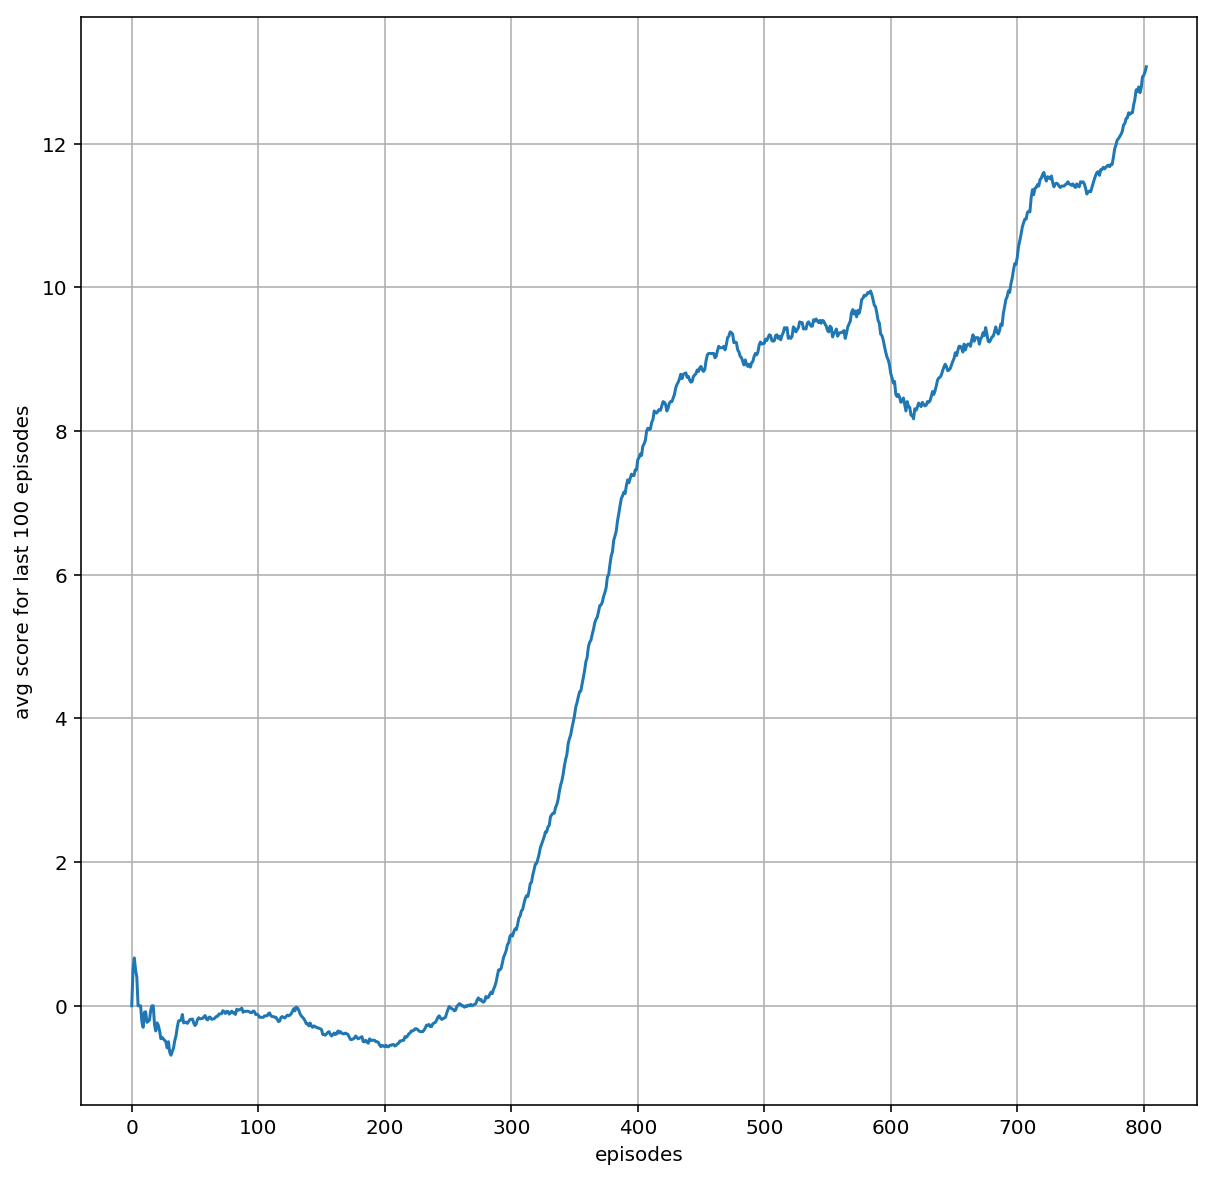

In [5]:
# plotting the avg reward curve
plt.figure(figsize=(10,10))
plt.plot(range(len(avg_scores)),avg_scores)
plt.xlabel('episodes')
plt.ylabel('avg score for last 100 episodes')
plt.grid()
plt.show()

In [ ]:
# lets visualise at how the trained agent performs

# reset env state
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]

done = env_info.local_done[0]
total_reward = 0

while not done:
    # choose action using the local q-network using low value of epsilon = 1e-2
    action = trained_agent.act(state,eps=1e-2)

    # taking action in the env
    env_info = env.step(vector_action=action)[brain_name]

    # getting next_state,reward,done from the env
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    
    # get total reward for the episode
    total_reward += reward
    
    # set current state = next_state
    state = next_state
    
print ("total reward : {:.2f}".format(total_reward))

In [ ]:
# closing the environment
env.close()